In [2]:
import sys; sys.path

['/Users/sahal/Documents/code/scotiabankfrauddetection',
 '/Users/sahal/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles',
 '/Users/sahal/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles/lib/python',
 '/Users/sahal/miniconda3/envs/tf/lib/python310.zip',
 '/Users/sahal/miniconda3/envs/tf/lib/python3.10',
 '/Users/sahal/miniconda3/envs/tf/lib/python3.10/lib-dynload',
 '',
 '/Users/sahal/miniconda3/envs/tf/lib/python3.10/site-packages']

Imports that we are using

In [24]:
import os 
import warnings

import numpy as np
import tensorflow as tf
import pandas as pd
from pandas import Series, DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition


#visuals
import seaborn as sns
import matplotlib.pyplot as plt


Checking to see that tensorflow works. Your output should contain a tf.tensor

In [4]:
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(-685.17163, shape=(), dtype=float32)


Preliminary Graphing

In [5]:
#Loading the dataset - abel
url = "https://raw.githubusercontent.com/25ohms/scotiabankfrauddetection/main/Winter%202023%20Discovery%20Days/train_ScotiaDSD.csv"
data = pd.read_csv(url)

x = data[['EVENT_MONTH', 'EVENT_DAY_OF_WEEK','EVENT_TIME','TRANSACTION_ID', 
    'FRAUD_FLAG','AVAIL_CRDT', 'AMOUNT', 'CREDIT_LIMIT', 'CARD_NOT_PRESENT', 
      'USER_AGENT', 'CITY']]



credible_data = data[data['FRAUD_FLAG'] == 0.0] 
fraudulent_data = data[data['FRAUD_FLAG'] == 1.0]

In [6]:
print(credible_data.head())

   EVENT_MONTH  EVENT_DAY_OF_WEEK EVENT_TIME TRANSACTION_ID  FRAUD_FLAG  \
1            2                  4      12:51       8352728b         0.0   
2            2                  4      15:26       d50120e1         0.0   
3            2                  4      16:19       e96e2139         0.0   
4            2                  4      8:15:       32502a99         0.0   
5            2                  4      16:27       1b4856fb         0.0   

   AVAIL_CRDT  AMOUNT  CREDIT_LIMIT  CARD_NOT_PRESENT  \
1    20371.88   96.35       30700.0                 1   
2    15628.17  193.72       19500.0                 0   
3    12913.98   47.15       18400.0                 0   
4    26779.35  121.88       29200.0                 1   
5    27484.35    6.83       30700.0                 0   

                                          USER_AGENT  ...  \
1  Mozilla/5.0 (iPhone; CPU OS 16_0 like Mac OS X...  ...   
2                                                NaN  ...   
3                      

In [7]:
print(fraudulent_data.head())

     EVENT_MONTH  EVENT_DAY_OF_WEEK EVENT_TIME TRANSACTION_ID  FRAUD_FLAG  \
0              2                  4      14:16       a316accb         1.0   
24             2                  4      20:02       5fcc42f8         1.0   
36             2                  4      19:59       0d060041         1.0   
38             2                  4      12:30       74bbbe44         1.0   
132            2                  4      16:28       c264fb24         1.0   

     AVAIL_CRDT  AMOUNT  CREDIT_LIMIT  CARD_NOT_PRESENT  \
0        537.10   11.70       29200.0                 1   
24      9016.80   50.23       21400.0                 1   
36      3135.47   41.00       19500.0                 1   
38       674.70  161.95        1000.0                 1   
132     1314.30   44.08        5100.0                 1   

                                            USER_AGENT  ...  \
0                                                  NaN  ...   
24   Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...  

Checking to see if Data is null

In [8]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,USER_AGENT,CITY,EVENT_MONTH,MAX_PHONE_ORDER_PAST_30DAY,MEAN_TRAVEL_AND_ENTERTAINMENT_PAST_30DAY,MEAN_WEEKEND_PAST_30DAY,MAX_AUTO_PAST_30DAY,MAX_LS_PAST_30DAY,MAX_ELCTRNCS_PAST_30DAY,MAX_FASTFOOD_PAST_30DAY,...,MAX_RECREA_PAST_7DAY,MAX_HIGH_AMT_PAST_7DAY,MAX_HIGH_RECREA_PAST_7DAY,MAX_INTERNET_PAST_7DAY,MAX_PHONE_ORDER_PAST_7DAY,MAX_PURCHASE_EXCLUDING_GAS_PAST_7DAY,MAX_SWIPE_PAST_7DAY,MAX_WEEKEND_PAST_7DAY,STD_LX_PAST_7DAY,PREV_M_UNEMP_RATE
Total,77322.000000,77322.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,86.654713,86.654713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
num_fraudulent = fraudulent_data.shape[0]
num_total = data.shape[0]

p_fraudulent = num_fraudulent / num_total
print(p_fraudulent)

0.024139863274683402


Suggests that the data is heavily unbalanced.

In [33]:
print(data.shape)

(89230, 175)


\section{Using PCA on Data}

In [28]:
target_variable = data['FRAUD_FLAG']
features_variable = data.drop(["FRAUD_FLAG", "TRANSACTION_ID", "USER_AGENT", "CITY", "EVENT_TIME"], axis=1)
print(target_variable.head())
print(features_variable.head())

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: FRAUD_FLAG, dtype: float64
   EVENT_MONTH  EVENT_DAY_OF_WEEK  AVAIL_CRDT  AMOUNT  CREDIT_LIMIT  \
0            2                  4      537.10   11.70       29200.0   
1            2                  4    20371.88   96.35       30700.0   
2            2                  4    15628.17  193.72       19500.0   
3            2                  4    12913.98   47.15       18400.0   
4            2                  4    26779.35  121.88       29200.0   

   CARD_NOT_PRESENT  FLAG_LX  FLAG_ATM  FLAG_AUTO  FLAG_CASH  ...  \
0                 1        0         0          1          0  ...   
1                 1        0         0          0          0  ...   
2                 0        0         0          0          0  ...   
3                 0        0         0          0          0  ...   
4                 1        0         0          0          0  ...   

   COUNT_LOW_AMT_PAST_30DAY  COUNT_MANUAL_ENTRY_PAST_30DAY  \
0                 

In [39]:
standarized_data = StandardScaler().fit_transform(features_variable)
pca = decomposition.PCA(n_components=28)
pca_data = pca.fit_transform(standarized_data)
print(pca_data)


[[ 2.49886099e+01 -1.23205122e+00 -1.00577396e+00 ... -1.62326853e+00
   2.11395524e+00 -1.18779367e+00]
 [ 5.06003452e+00 -1.17645231e+00 -4.03269661e+00 ... -8.74749866e-01
  -3.38923824e-01 -6.61053439e-01]
 [ 1.40465555e+01  2.97197946e+00 -6.86756668e+00 ...  2.86209696e-01
  -2.04244916e+00 -2.00748376e+00]
 ...
 [-3.74841643e+00  2.92833068e+00 -1.10588785e+00 ... -9.54245664e-01
  -1.74116909e-01 -1.21159032e+00]
 [ 4.42998287e-01 -1.91000021e-02 -1.09151758e+00 ...  8.11870591e-01
   3.72357244e-01 -1.07625949e+00]
 [ 1.85599865e+00 -2.14992533e+00  2.38660570e+00 ... -2.11168008e-01
   1.70551127e+00  8.16205599e-01]]


\subsection{Scree Plot}
Determining number of factors we wish to use in our exploratory factor analysis to keep in a PCA.

Text(0, 0.5, 'Retention value on scale of 1')

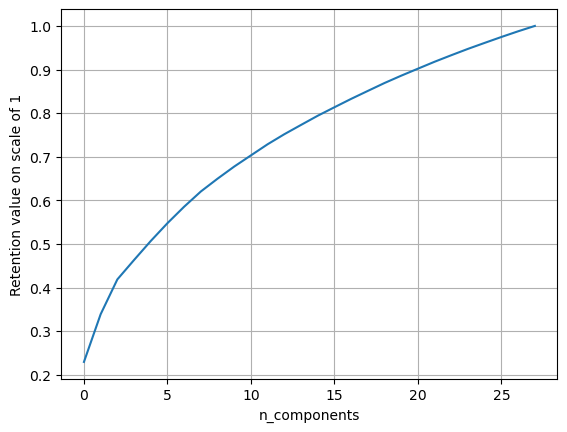

In [40]:
pca.n_components = 170

retention_value = pca.explained_variance_ / np.sum(pca.explained_variance_);
cumulative_retention = np.cumsum(retention_value)

plt.plot(cumulative_retention)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Retention value on scale of 1')

In [36]:
print(pca_data.shape)

(89230, 28)
